# NHL Canucks - Retention Score Distribution
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 28, 2022

In [133]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from datetime import datetime
from pytz import timezone
from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [134]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [135]:
lkupclientid = 7 # canucks
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCanucks].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(32920, 54)

### We should specify the features used in our model:

In [137]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (23643, 10)
Unseen Data For Predictions: (4172, 10)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [138]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "productGrouping",
        "recentDate",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [139]:
model_matrix = compare_models(
    fold= 10,
    include= ["gbc","lightgbm","lr","xgboost"],
    n_select= 4,
    probability_threshold= 0.75
)
results = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7126,0.8608,0.5179,0.8743,0.6503,0.4324,0.4755,0.3130
lightgbm,Light Gradient Boosting Machine,0.6919,0.8491,0.4664,0.8810,0.6096,0.3928,0.4475,0.1580
gbc,Gradient Boosting Classifier,0.6367,0.8155,0.3396,0.8864,0.4909,0.2873,0.3679,0.3990
lr,Logistic Regression,0.5276,0.6937,0.1183,0.7786,0.2050,0.0803,0.1531,0.0170


In [140]:
models = []
for idx, m in enumerate(model_matrix):
    
    model = create_model(m)
    final_model = finalize_model(model)
    
    models.append({
        "name": str(results.iloc[idx]["Model"]),
        "model": final_model
    })

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5229,0.7001,0.1050,0.7842,0.1852,0.0720,0.1460
1,0.5279,0.6959,0.1137,0.8027,0.1992,0.0815,0.1609
2,0.5249,0.6830,0.1175,0.7578,0.2035,0.0753,0.1425
3,0.5308,0.7044,0.1176,0.8133,0.2056,0.0864,0.1690
4,0.5204,0.6939,0.1022,0.7626,0.1803,0.0664,0.1345
5,0.5284,0.6963,0.1273,0.7543,0.2178,0.0809,0.1473
6,0.5431,0.6765,0.1533,0.7990,0.2573,0.1092,0.1877
7,0.5401,0.6964,0.1398,0.8192,0.2389,0.1040,0.1885
8,0.5187,0.6875,0.0993,0.7574,0.1756,0.0635,0.1300
9,0.5192,0.7026,0.1070,0.7351,0.1869,0.0641,0.1249


### Let's load in our 2021 season data and get retention scores using the model:

In [141]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(5105, 10)

In [142]:
predictions = []
for idx, final_m in enumerate(models):
    
    df_predictions = (predict_model(final_m['model'], data=df_inference, raw_score=True))
    df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]
    final_m["predictions"] = df_predictions

### We can create some histograms to visualize each model distribution:

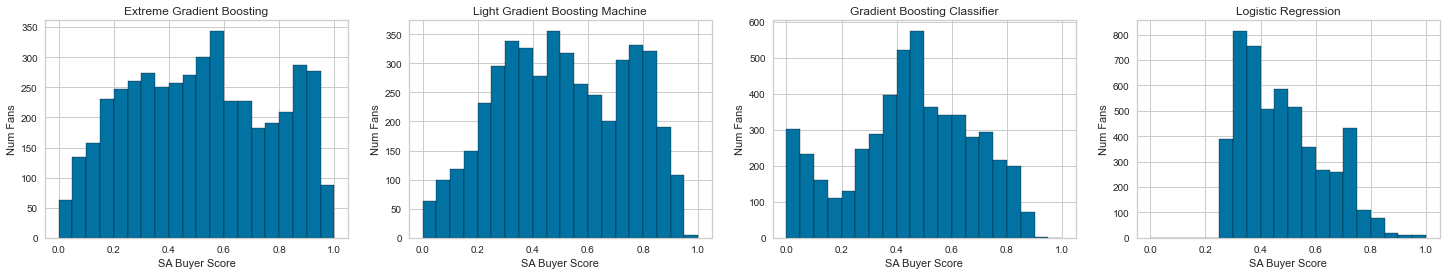

In [143]:
for idx, model in enumerate(models):
    
    plt.subplot(1, 4, idx+1)
    plt.title(model["name"])
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")
    plt.hist(model["predictions"]["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### We can also see how many purchases there are in each range of scores:

In [144]:
df_new = pd.DataFrame()

for idx, model in enumerate(models):
    df_new["Score"] = df_new.index
    df_new[str(models[idx]["name"])] = models[idx]["predictions"]["Score_1"].value_counts(bins=np.arange(0, 1.05, 0.05)).sort_index(ascending=False)

df_new.reset_index(inplace=True, drop=True)
df_new

,Score,Extreme Gradient Boosting,Light Gradient Boosting Machine,Gradient Boosting Classifier,Logistic Regression
0,"(0.95, 1.0]",88,5,0,10
1,"(0.9, 0.95]",274,108,1,10
2,"(0.85, 0.9]",290,190,73,18
3,"(0.8, 0.85]",209,321,199,78
4,"(0.75, 0.8]",190,332,216,111
5,"(0.7, 0.75]",182,305,293,431
6,"(0.65, 0.7]",227,200,280,259
7,"(0.6, 0.65]",228,246,341,267
8,"(0.55, 0.6]",344,265,340,357
9,"(0.5, 0.55]",301,317,367,513


### Select the model you would like to use for updating scores:

In [145]:
selected_model = "Extreme Gradient Boosting"

for model in models:
    if model["name"] == selected_model:

        df_scores = model["predictions"]
                                 
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4479 entries, 27815 to 32918
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  4479 non-null   int64  
 1   attendancePercent    4479 non-null   float64
 2   distToVenue          4479 non-null   float64
 3   isNextYear_Buyer     4479 non-null   int64  
 4   productGrouping      4479 non-null   object 
 5   recency              4479 non-null   int64  
 6   recentDate           4479 non-null   object 
 7   source_tenure        4479 non-null   int64  
 8   totalSpent           4479 non-null   float64
 9   year                 4479 non-null   int64  
 10  Label                4479 non-null   int64  
 11  Score_0              4479 non-null   float32
 12  Score_1              4479 non-null   float32
dtypes: float32(2), float64(3), int64(6), object(2)
memory usage: 454.9+ KB


### Optionally we can push these scores into QA so that we can see what the new scoring looks like in the CDP:

In [ ]:
# connect to SQL Server.
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)
cursor = cnxn.cursor()

date_time_now = datetime.now().strftime("%m-%d-%Y %H:%M:%S")

try:
    # Insert Dataframe into SQL Server:
    for index, row in df_scores.iterrows():
        
        fields = f"""
            INSERT INTO ds.customerScores (
                dimCustomerMasterId,
                buyer_score,
                tenuredays,
                attendancePercentage,
                mostrecentattendance,
                year,
                lkupclientid,
                productgrouping,
                seasonYear,
                insertDate
            )
        """
        
        values = f"""
            VALUES(
                {str(row.dimCustomerMasterId)},
                {str(round(row.Score_1,4))},
                {str(row.source_tenure)},
                {str(row.attendancePercent)},
                '{str(row.recentDate)}',
                {str(row.year)},
                {str(lkupclientid)},
                '{str(row.productGrouping)}',
                {str(row.year)},
                '{str(date_time_now)}'
            )"""
        
        insert_statement = fields + values
        
        cursor.execute(insert_statement)
        cnxn.commit()

except Exception as err:
    print("ERROR INSERTING RETENTION SCORES TO DATABASE:", err)
        
cursor.close()
print("RETENTION SCORES WRITTEN TO DATABASE")

### Run the stored procedure to push scores from Data Science table to Stlr table:

In [130]:
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)
cursor = cnxn.cursor()

try:
    cursor.execute(
        f"Exec [DataScience].[DW].[factCustomerretention_INCR_LOAD_procVersion] {lkupclientid}, 2021"
    )
    cnxn.commit()

except Exception as err:
    print("ERROR RUNNING RETENTION SCORE STORED PROCEDURE:", err)